<a href="https://colab.research.google.com/github/Thalitarouth/Modelos-preditivos/blob/main/Aula_2_Regress%C3%A3o_linear_Garcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv


--2025-02-27 09:22:12--  https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1565376 (1.5M) [text/plain]
Saving to: ‘yield_df.csv’

yield_df.csv        100%[===================>]   1.49M  --.-KB/s    in 0.09s   

2025-02-27 09:22:13 (17.1 MB/s) - ‘yield_df.csv’ saved [1565376/1565376]



In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [3]:
crop = pd.read_csv("yield_df.csv")

crop

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [4]:
crop["Item"].unique()

array(['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat',
       'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams'],
      dtype=object)

In [5]:
item = "Soybeans"

product = crop[(crop["Item"] == item)]

product_crop = product[["avg_temp","hg/ha_yield"]]

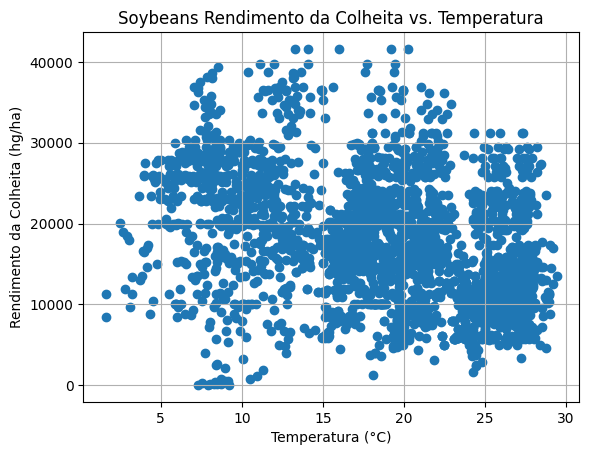

In [6]:
plt.scatter(product_crop['avg_temp'], product_crop['hg/ha_yield'])
plt.title(item + ' Rendimento da Colheita vs. Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Rendimento da Colheita (hg/ha)')
plt.grid(True)
plt.show()

In [7]:
t = product["avg_temp"]
obs = product["hg/ha_yield"]
with pm.Model() as crop_model:
  a = pm.Normal("a",100000,20000)
  b = pm.Normal("b",-2000,10000)

  eps = pm.Normal("eps",0,10000)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs)

In [8]:
crop_model

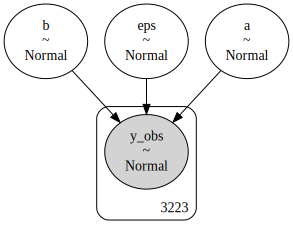

In [9]:
pm.model_to_graphviz(crop_model)

In [10]:
with crop_model:
  trace = pm.sample()

Output()

In [11]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,26108.431,400.712,25333.804,26811.555,14.057,9.943,816.0,949.0,1.00
b,-476.682,19.264,-511.408,-439.409,0.677,0.479,812.0,995.0,1.00
eps,6942.184,84.037,6793.482,7108.576,2.527,1.788,1108.0,961.0,1.01


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'eps'}>], dtype=object)

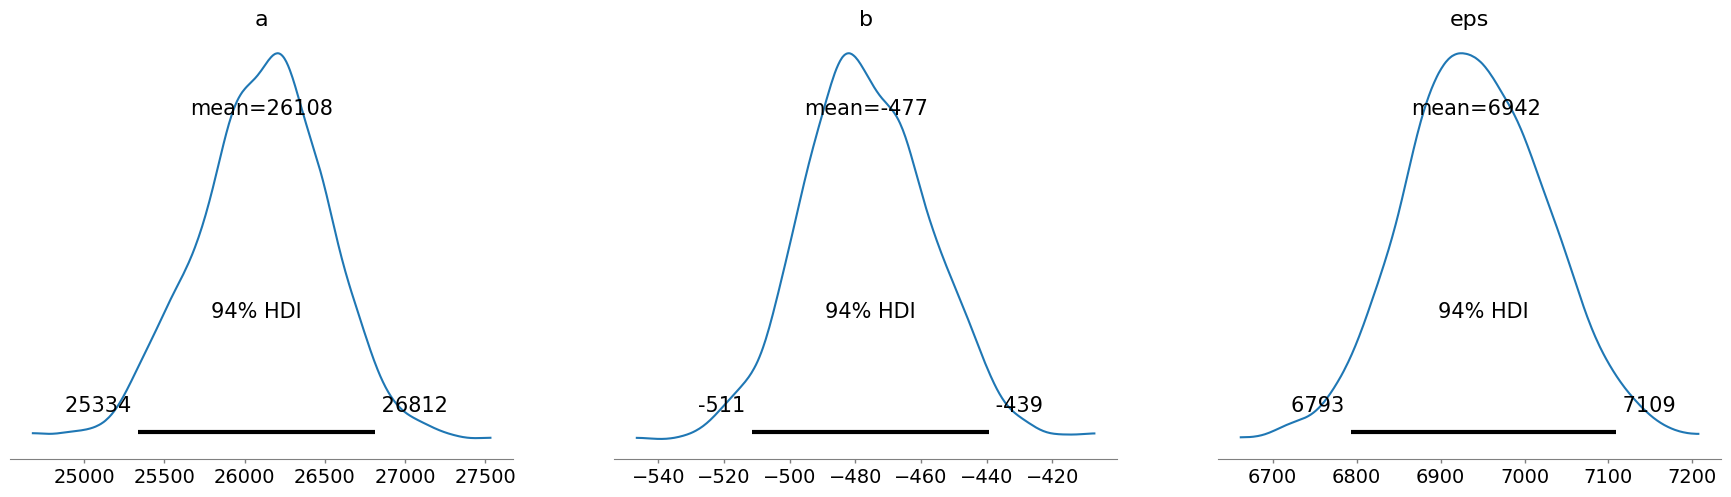

In [12]:
az.plot_posterior(trace)

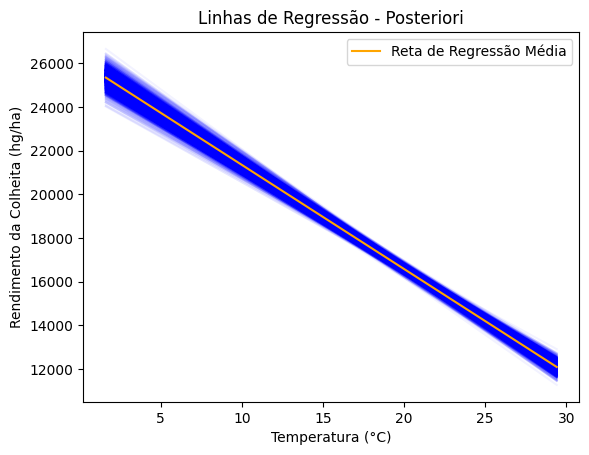

In [14]:
a_samples = trace.posterior["a"].values.flatten()
b_samples = trace.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", label="Reta de Regressão Média")

#plt.scatter(t, obs, color="red", label="Observed Data", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

In [15]:
obs_norm = (obs - obs.mean())/obs.std()

obs_norm

,hg/ha_yield
4,-1.279866
10,-1.402708
16,-1.607753
21,-1.148605
25,-1.157943
...,...
28207,-0.227679
28215,-0.417467
28223,-0.615147
28231,-0.188222


In [16]:
with pm.Model() as crop_model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)


In [17]:
with crop_model_norm:
  trace_norm = pm.sample()

Output()

<ipython-input-18-c0f517ba30e9>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


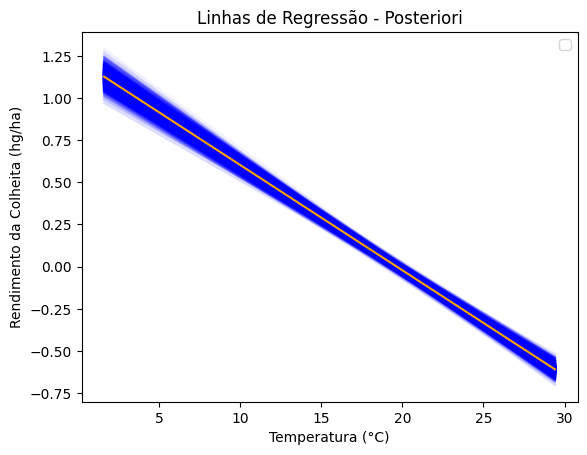

In [18]:
a_samples = trace_norm.posterior["a"].values.flatten()
b_samples = trace_norm.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

In [19]:
pm.summary(trace_norm)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.227,0.051,1.131,1.320,0.002,0.001,822.0,867.0,1.0
b,-0.062,0.002,-0.067,-0.058,0.000,0.000,834.0,1040.0,1.0
eps,0.914,0.012,0.894,0.936,0.000,0.000,959.0,963.0,1.0


In [20]:
with pm.Model() as crop_lasso:
  a = pm.Laplace("a",0,1)
  b = pm.Laplace("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [21]:
with crop_lasso:
  trace_lasso = pm.sample()

Output()

In [22]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.230,0.052,1.133,1.333,0.002,0.001,860.0,622.0,1.0
b,-0.063,0.003,-0.068,-0.058,0.000,0.000,872.0,632.0,1.0
eps,0.914,0.011,0.894,0.936,0.000,0.000,1236.0,1136.0,1.0


<ipython-input-23-20f3873a0f08>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


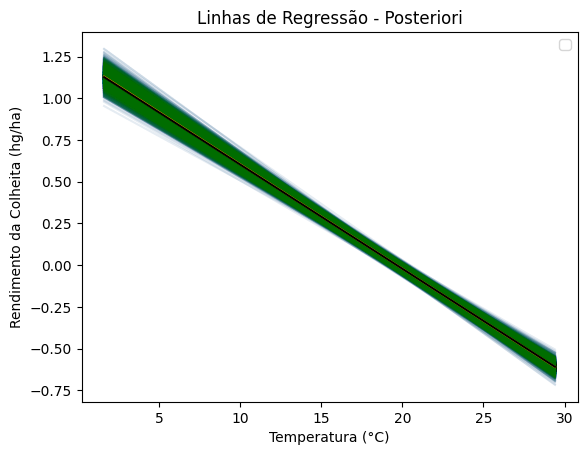

In [23]:
a_samples = trace_lasso.posterior["a"].values.flatten()
b_samples = trace_lasso.posterior["b"].values.flatten()

a_samples_r = trace_norm.posterior["a"].values.flatten()
b_samples_r = trace_norm.posterior["b"].values.flatten()

t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

for a_sample_r, b_sample_r in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample_r + b_sample_r * t_values, color="green", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange" )

mean_a_r = a_samples_r.mean()
mean_b_r = b_samples_r.mean()
plt.plot(t_values, mean_a_r + mean_b_r * t_values, color="black" )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

In [24]:
with pm.Model() as crop_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)
  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t,sigma=eps,observed=obs_norm)

In [25]:
with crop_robust:
  trace_robust = pm.sample()

Output()

In [26]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.338,0.053,1.236,1.434,0.002,0.001,865.0,754.0,1.0
b,-0.070,0.003,-0.075,-0.065,0.000,0.000,854.0,775.0,1.0
df,7.174,0.990,5.470,8.977,0.033,0.025,923.0,965.0,1.0
eps,0.786,0.018,0.752,0.819,0.001,0.000,926.0,947.0,1.0


<ipython-input-27-3341e08faf30>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


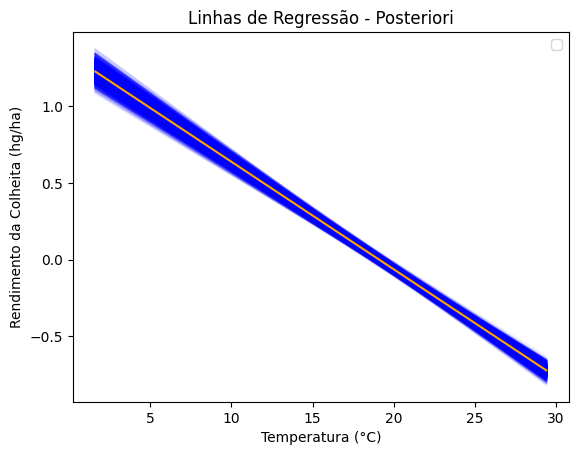

In [27]:
a_samples = trace_robust.posterior["a"].values.flatten()
b_samples = trace_robust.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

In [28]:
with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

with crop_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

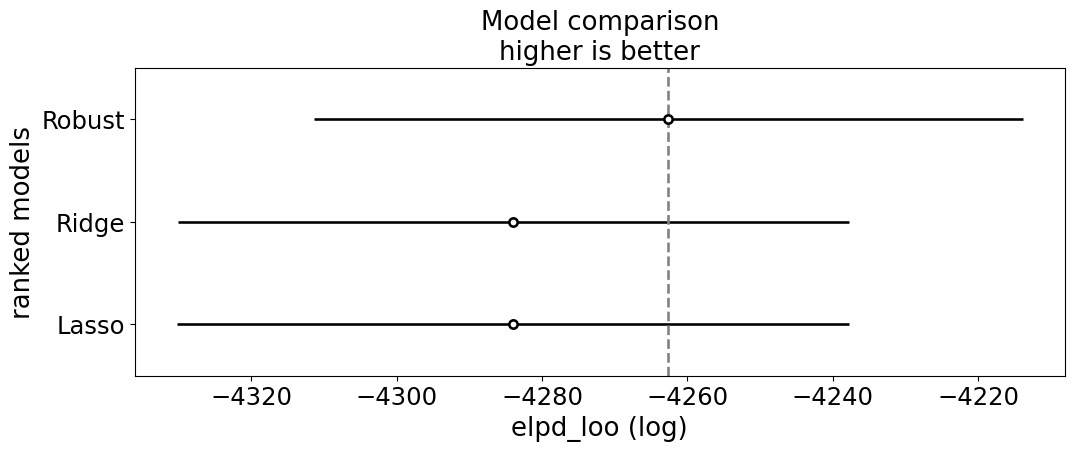

In [29]:
model_compare = az.compare(
    {
        "Ridge": trace_norm,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [30]:
model_compare


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Robust,0,-4262.611725,4.083365,0.000000,0.983786,48.680246,0.000000,False,log
Ridge,1,-4283.937006,3.269771,21.325281,0.008525,46.165253,8.860881,False,log
Lasso,2,-4284.012661,3.339011,21.400936,0.007688,46.168880,8.851540,False,log


In [31]:
az.loo(trace_norm)

,0
elpd_loo,-4283.937006
se,45.075378
p_loo,3.269771
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [32]:
az.loo(trace_lasso)

,0
elpd_loo,-4284.012661
se,45.077104
p_loo,3.339011
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [33]:
az.loo(trace_robust)

,0
elpd_loo,-4262.611725
se,47.345316
p_loo,4.083365
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


Exercícios
1) Inclua um modelo de regressão linear sem regularização. Para isso use um flat prior. Inclua este modelo na comparação. Esse modelo possui uma capacidade preditiva melhor que os outros?
2) Refaça os modelos de regressão de Ridge, Lasso e Robusto para o item graõs de soja ao invés de batatas.
3) O modelo robusto acima diferiu dos outros significativamente? Plote as retas comparando os modelos.
4) Identifique o melhor modelo usando o ELPD LOO.
Faça os modelos de regressão e analise o melhor usando as relações crop yield vs pesticide e crop yield vs rain fall. Você terá que usar a função groupby do pandas.

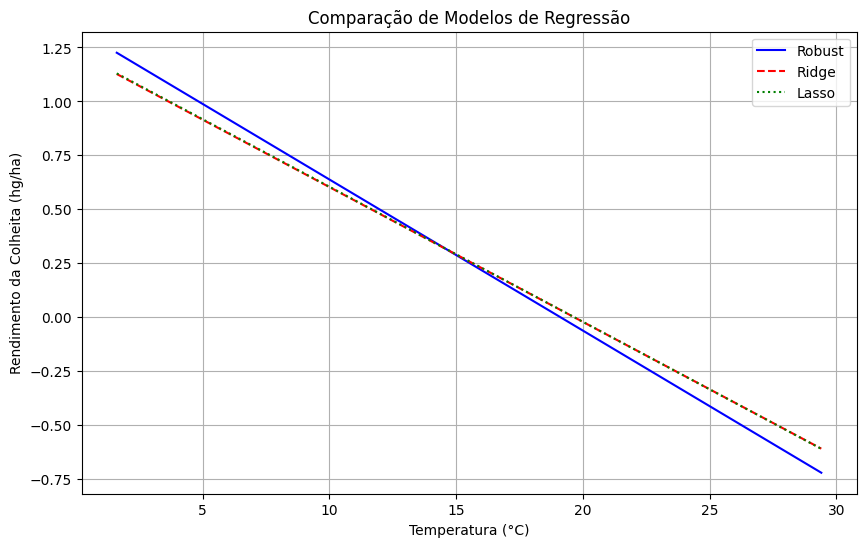

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# ... (previous code to define and fit models) ...

# Get samples for each model
robust_a_samples = trace_robust.posterior["a"].values.flatten()
robust_b_samples = trace_robust.posterior["b"].values.flatten()

ridge_a_samples = trace_norm.posterior["a"].values.flatten()
ridge_b_samples = trace_norm.posterior["b"].values.flatten()

lasso_a_samples = trace_lasso.posterior["a"].values.flatten()
lasso_b_samples = trace_lasso.posterior["b"].values.flatten()

# Create x-values for plotting
t_values = np.linspace(t.min(), t.max(), 100)

# Plot regression lines for each model
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Robust model
plt.plot(t_values, robust_a_samples.mean() + robust_b_samples.mean() * t_values, color="blue", label="Robust", linestyle='-')

# Ridge model
plt.plot(t_values, ridge_a_samples.mean() + ridge_b_samples.mean() * t_values, color="red", label="Ridge", linestyle='--')

#Lasso model
plt.plot(t_values, lasso_a_samples.mean() + lasso_b_samples.mean() * t_values, color="green", label="Lasso", linestyle=':')

# plt.scatter(t, obs_norm, color="gray", alpha=0.5, label="Observed Data")

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Comparação de Modelos de Regressão")
plt.legend()
plt.grid(True)
plt.show()

Identifique o melhor modelo usando o ELPD LOO.

In [37]:
az.loo(trace_robust)

,0
elpd_loo,-4262.611725
se,47.345316
p_loo,4.083365
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [38]:
az.loo(trace_norm)

,0
elpd_loo,-4283.937006
se,45.075378
p_loo,3.269771
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [39]:
az.loo(trace_lasso)

,0
elpd_loo,-4284.012661
se,45.077104
p_loo,3.339011
n_samples,2000
n_data_points,3223
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [49]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Load the dataset (assuming it's already loaded as 'crop')
# crop = pd.read_csv("yield_df.csv")

# Group data by item and calculate the mean for each group
grouped_data = crop.groupby('Item')[['pesticides_tonnes', 'hg/ha_yield','average_rain_fall_mm_per_year', ]].mean().reset_index()

In [50]:
item = "Soybeans"  # Choose the desired crop item
data = grouped_data[grouped_data['Item'] == item]

# Extract variables
pesticide = data['pesticides_tonnes'].values
yield_data = data['hg/ha_yield'].values

# Normalize yield data
yield_norm = (yield_data - yield_data.mean()) / yield_data.std()

# Define and fit models (Ridge, Lasso, Robust - similar structure as before)
# ... (model definitions using pesticide as predictor and yield_norm as outcome) ...

<ipython-input-50-327e27dd3070>:9: RuntimeWarning: invalid value encountered in divide
  yield_norm = (yield_data - yield_data.mean()) / yield_data.std()


In [51]:
# Extract rainfall data
rainfall = data['rainfall'].values

# Define and fit models (Ridge, Lasso, Robust - similar structure as before)
# ... (model definitions using rainfall as predictor and yield_norm as outcome) ...

KeyError: 'rainfall'